In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from google.colab.patches import cv2_imshow

!git clone https://github.com/fernandogabrieu/Projeto-PDI.git

Cloning into 'Projeto-PDI'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 307 (delta 5), reused 87 (delta 1), pack-reused 214
Receiving objects: 100% (307/307), 70.25 MiB | 32.16 MiB/s, done.
Resolving deltas: 100% (9/9), done.


#Normalização das imagens

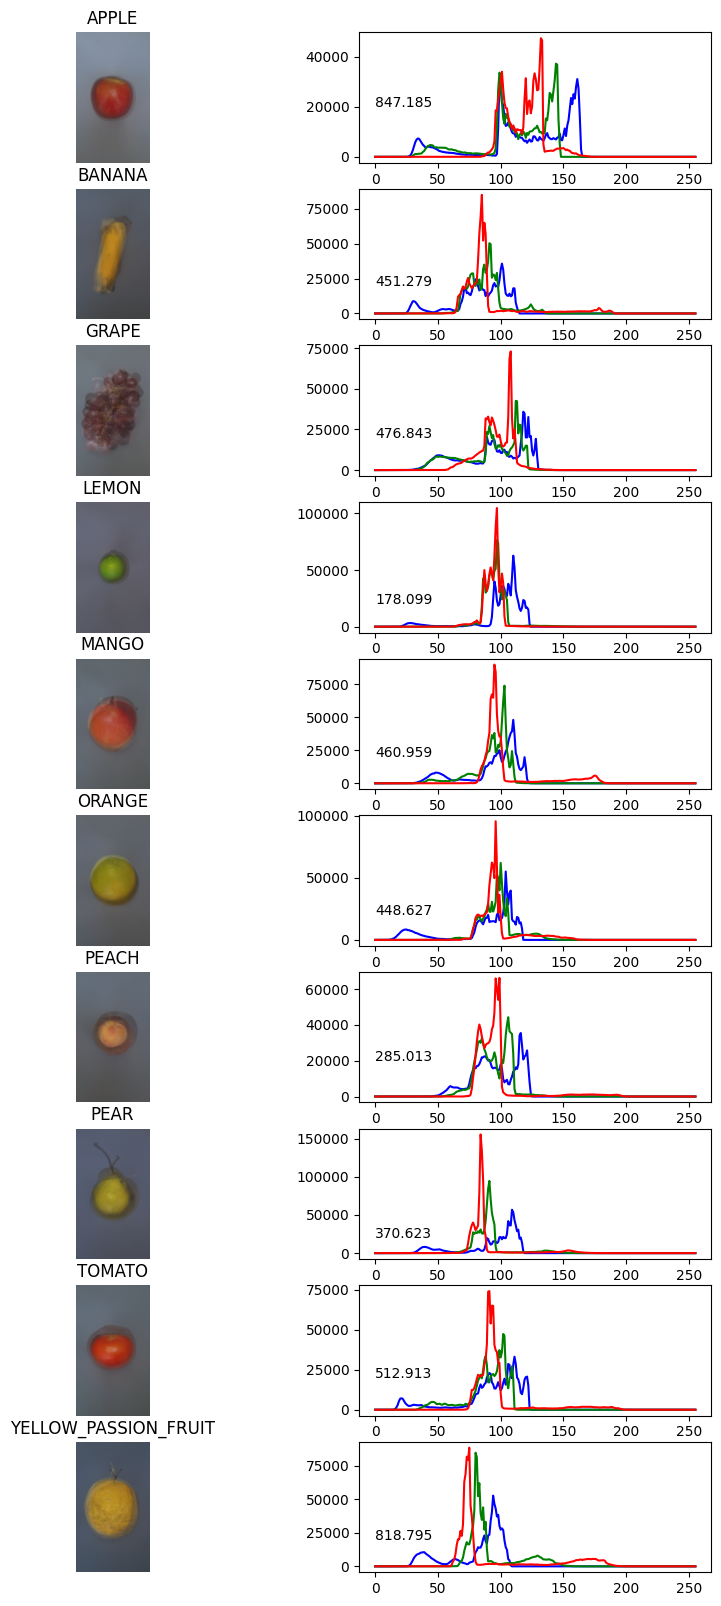

In [2]:
classes = ['APPLE', 'BANANA', 'GRAPE', 'LEMON', 'MANGO', 'ORANGE', 'PEACH', 'PEAR', 'TOMATO', 'YELLOW_PASSION_FRUIT']

f, axs = plt.subplots(10, 2, figsize=(10, 20))
#Acessa o diretório das imagens de cada classe e coloca as imagens na lista 'images'
i = 0
for classe in classes:
  pasta = f'/content/Projeto-PDI/fruits-images-augmented/{classe}/*.png'
  images_path = glob.glob(pasta)
  images = []

  for image_path in images_path:
    img = cv2.imread(image_path)
    images.append(img)

  # Plotando o protótipo de cada classe

  images = np.array(images)
  prototype = np.uint8(np.average(images, axis=0))
  axs[i][0].imshow(cv2.cvtColor(prototype, cv2.COLOR_BGR2RGB))
  axs[i][0].axis('off')
  axs[i][0].set_title(classe)

  # Plotar histograma de cada classe

  colors = ('b','g','r')
  var = np.var(prototype)
  rounded=round(var,3)
  for j, color in enumerate(colors):
      hist = cv2.calcHist([prototype],[j],None,[256],[0,256])
      axs[i][1].plot(hist, color = color)
  axs[i][1].text(0, 20000, rounded)
  i += 1

#Segmentação das imagens

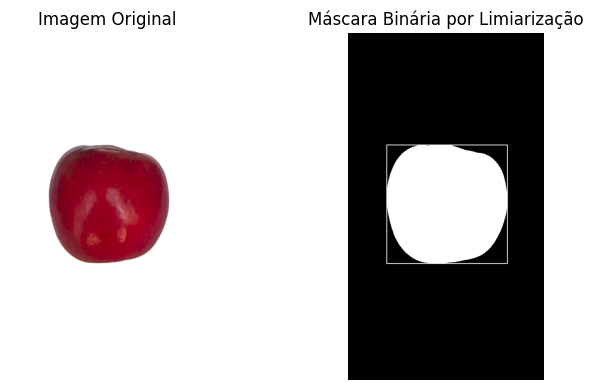

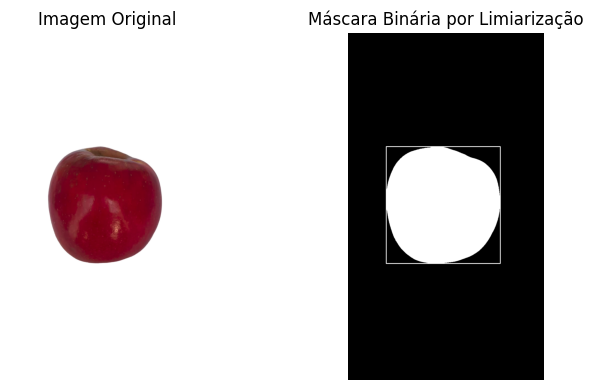

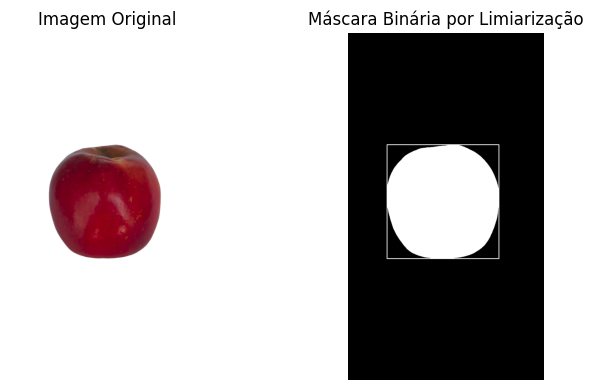

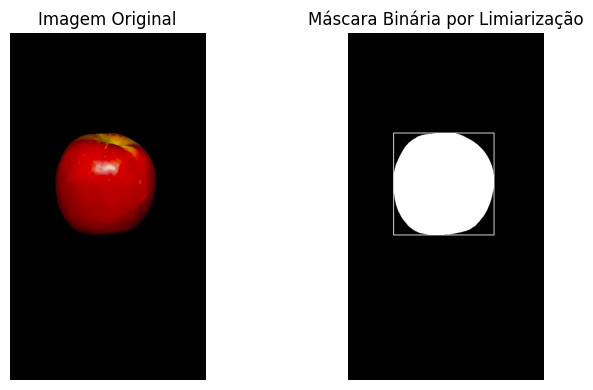

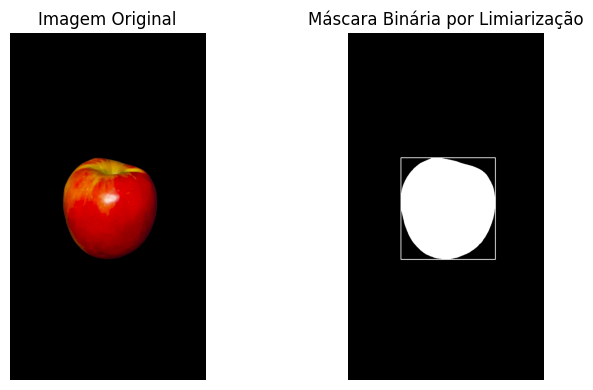

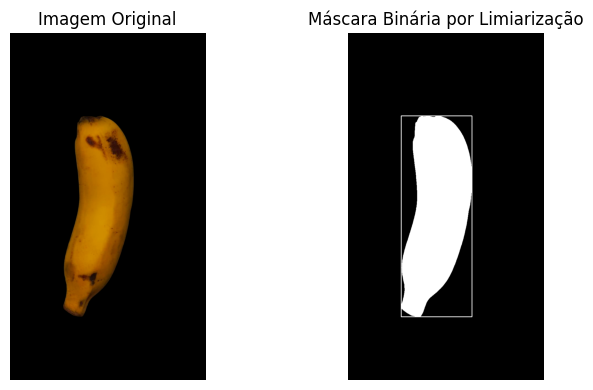

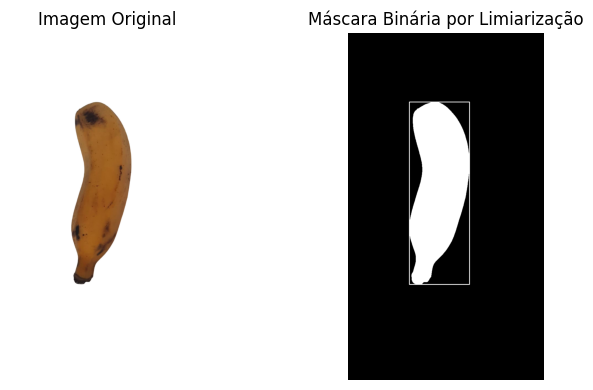

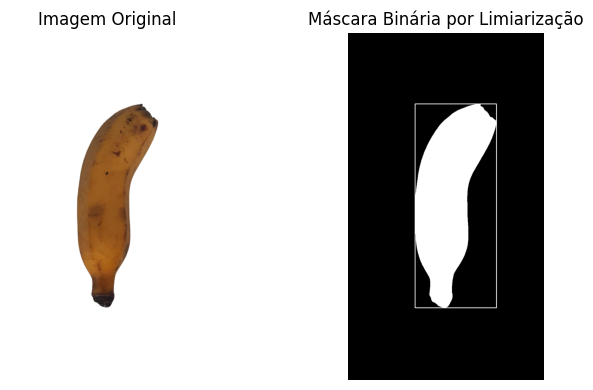

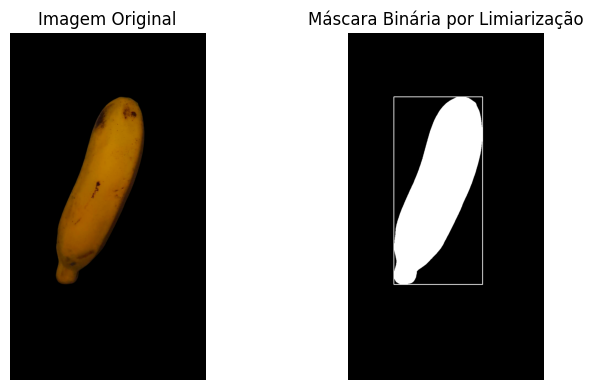

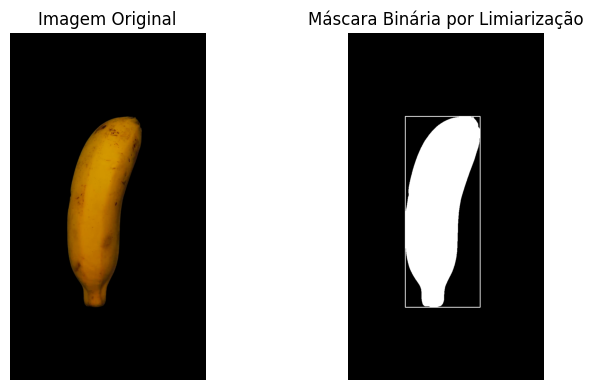

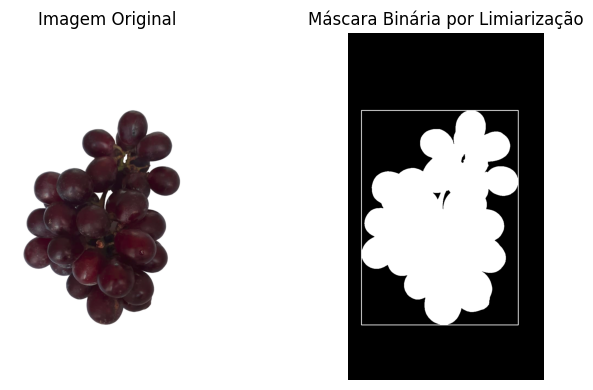

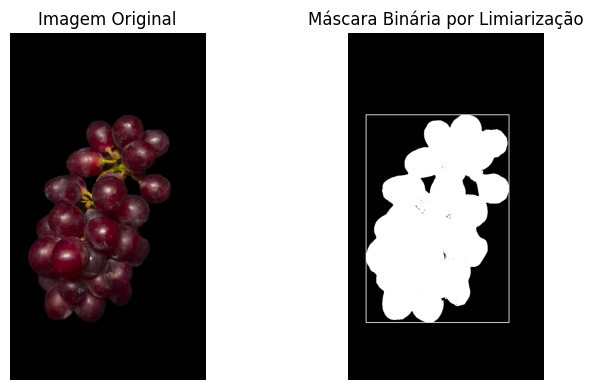

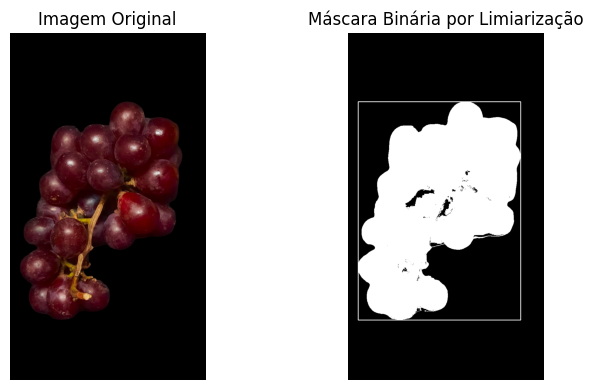

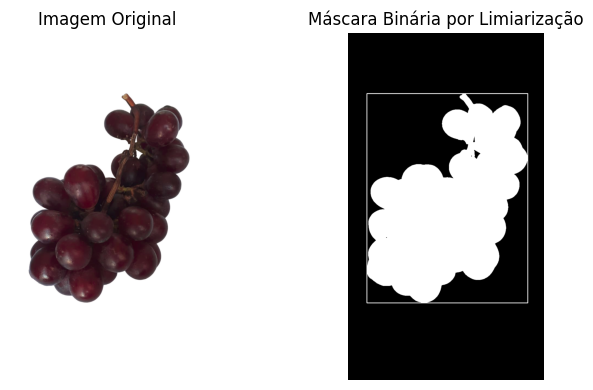

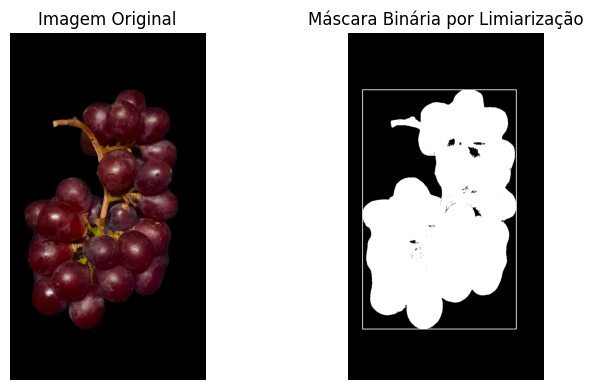

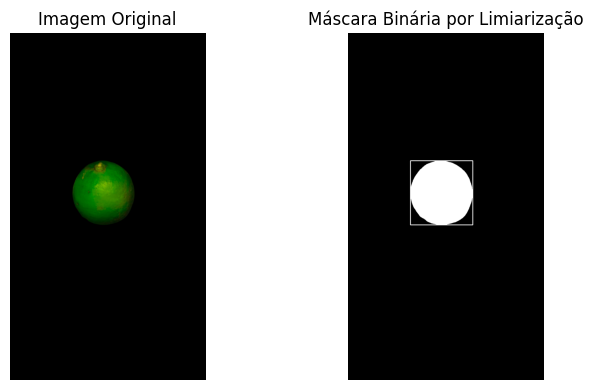

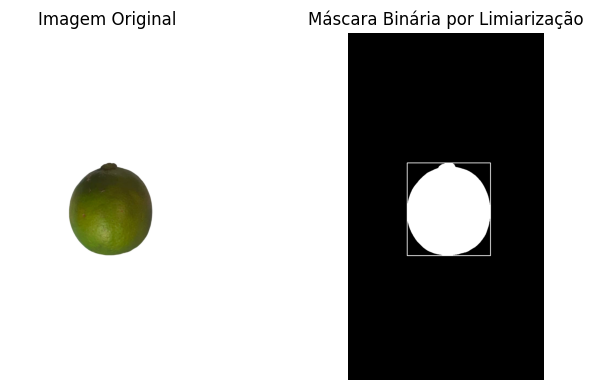

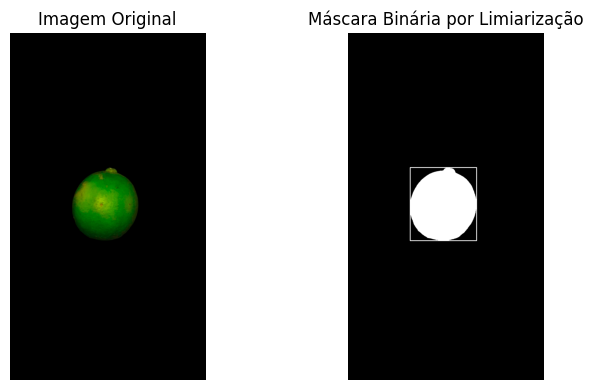

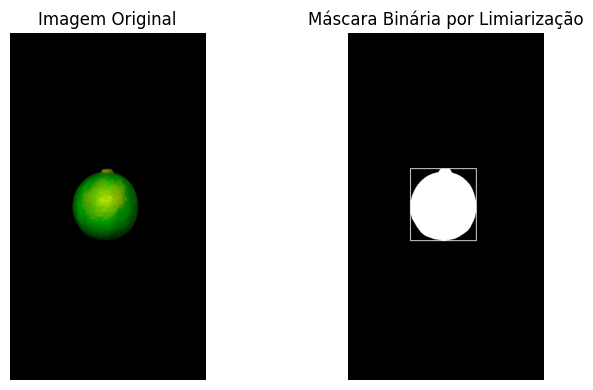

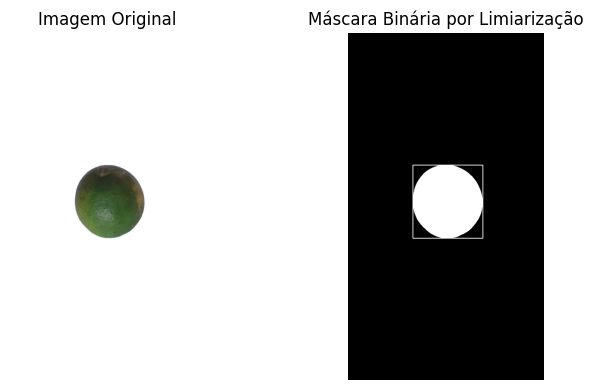

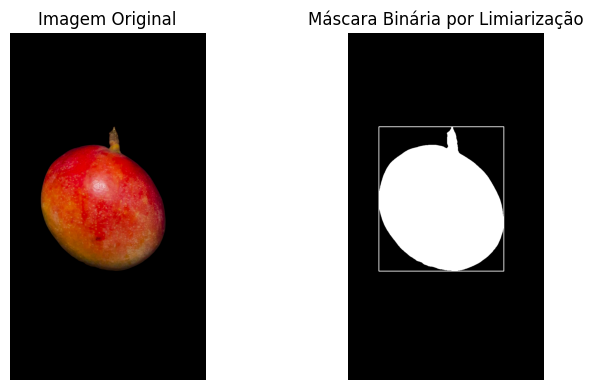

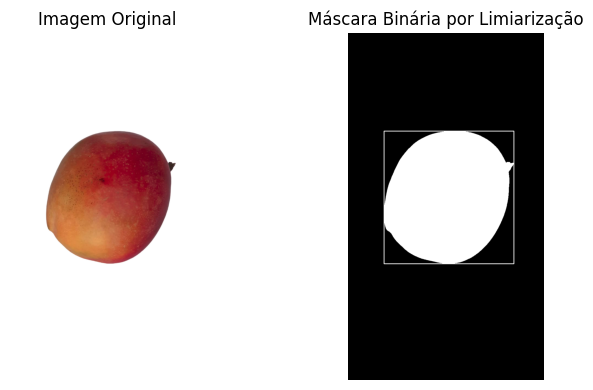

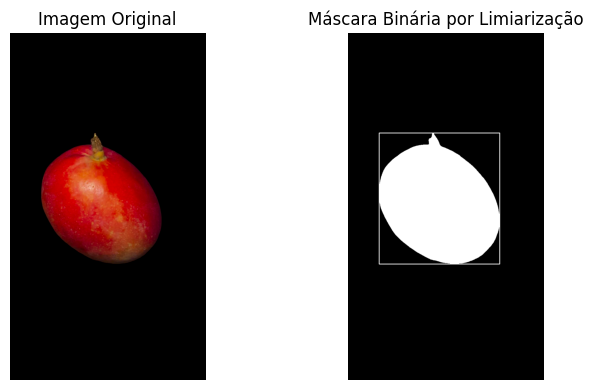

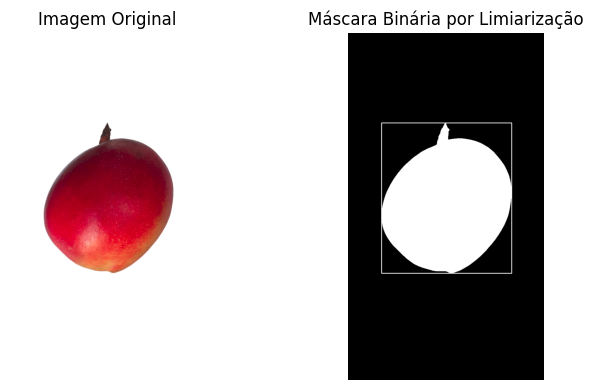

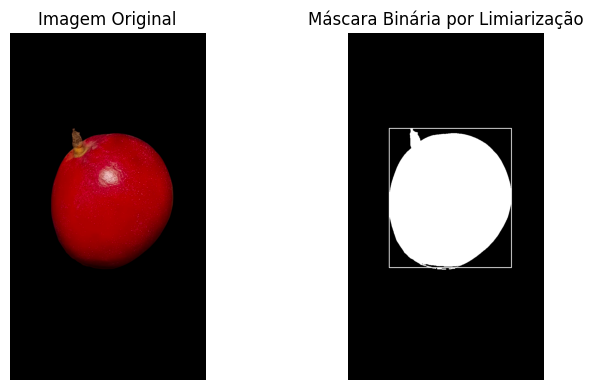

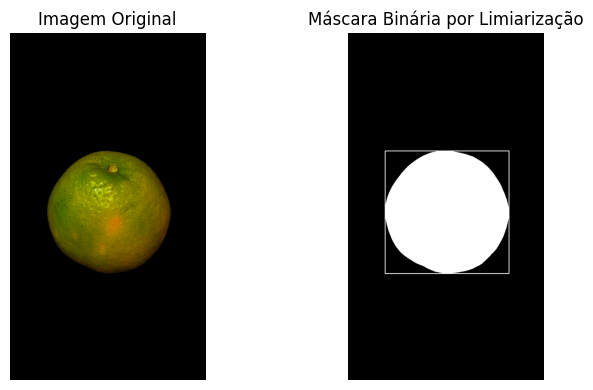

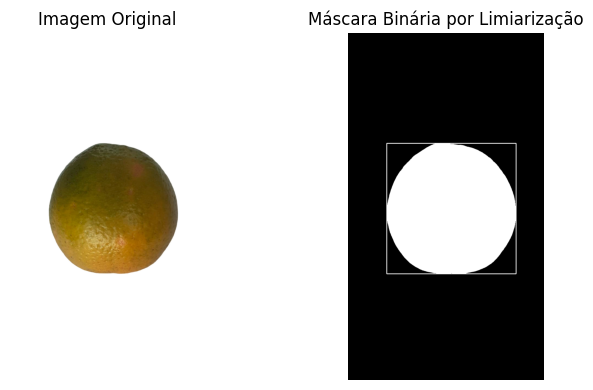

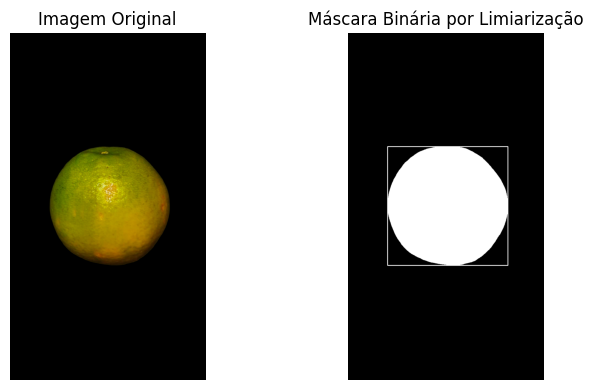

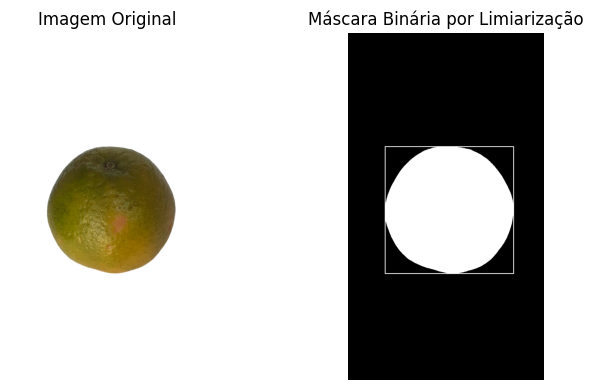

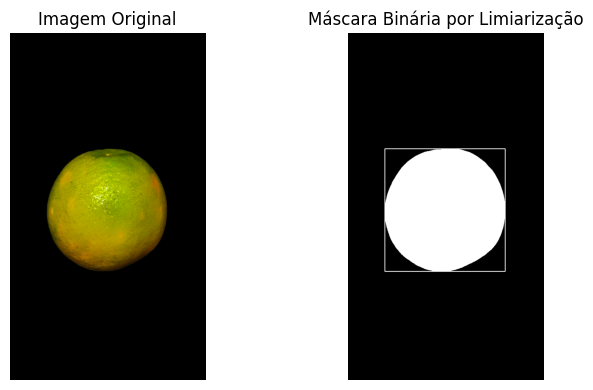

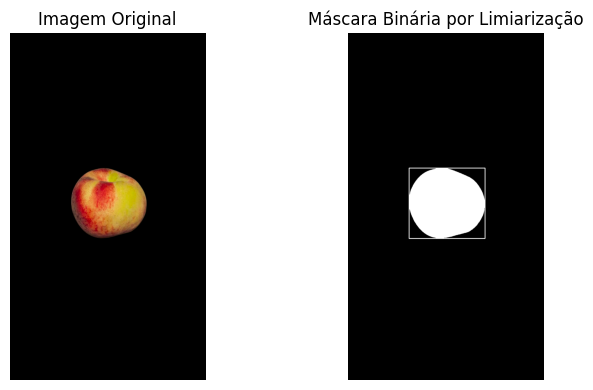

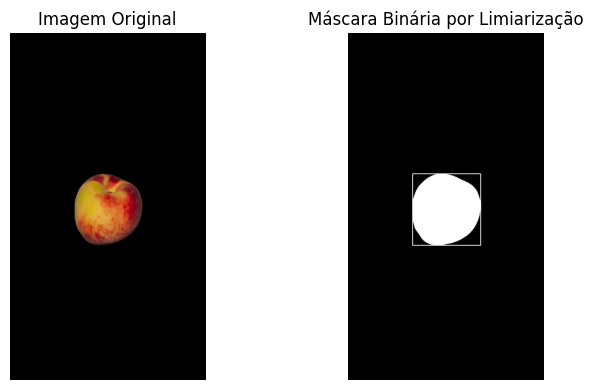

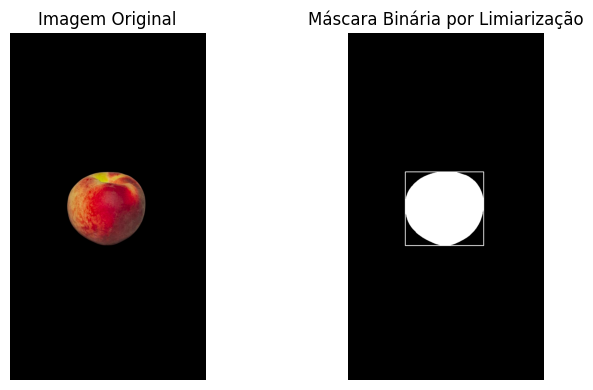

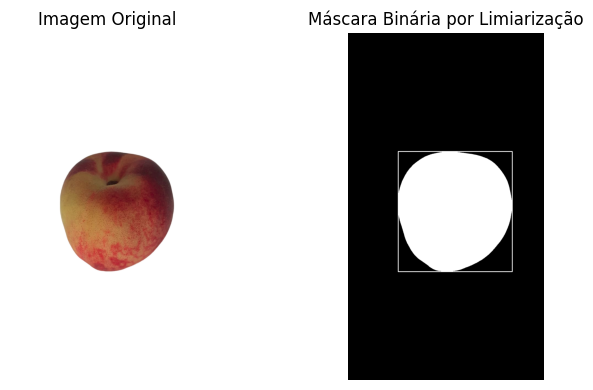

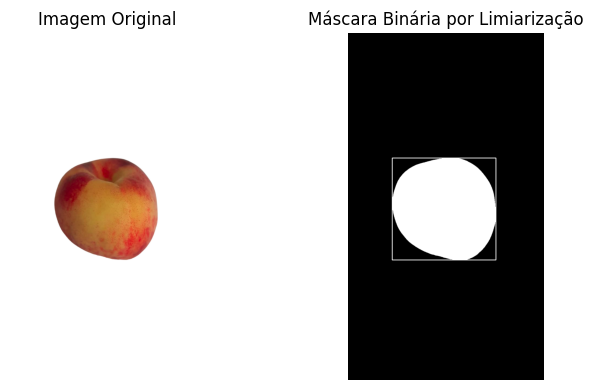

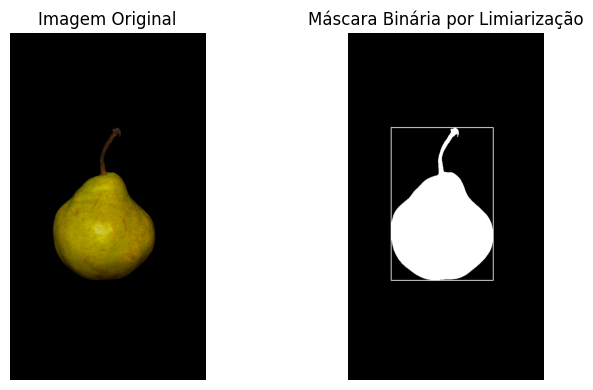

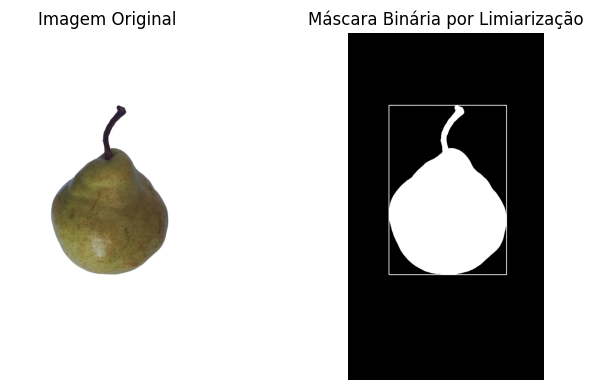

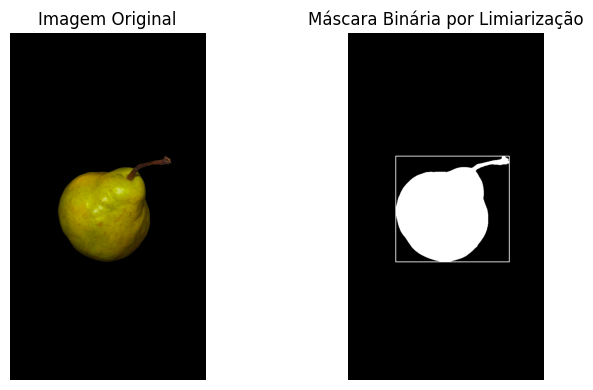

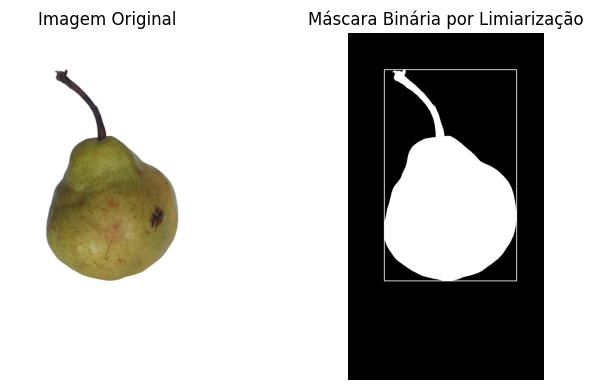

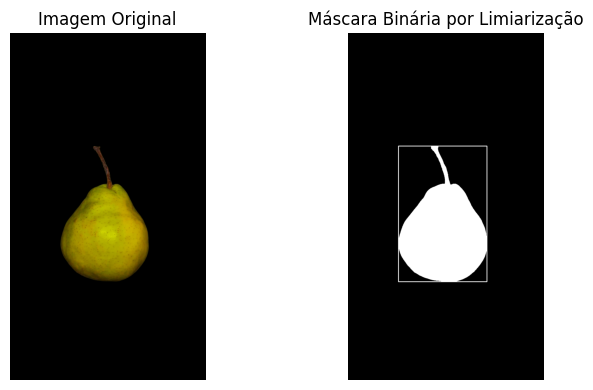

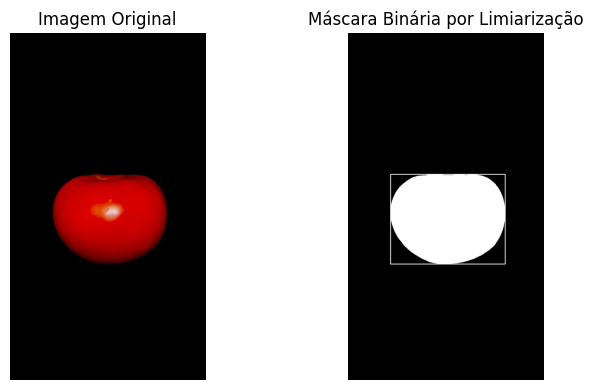

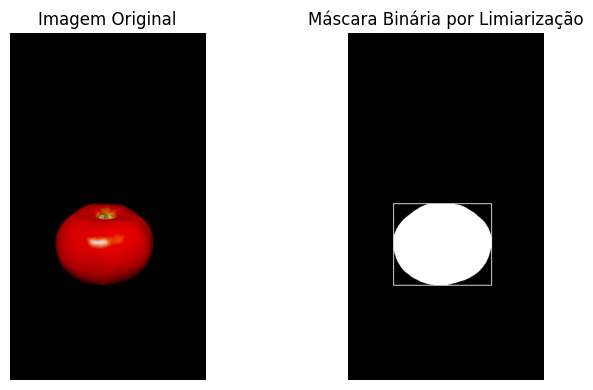

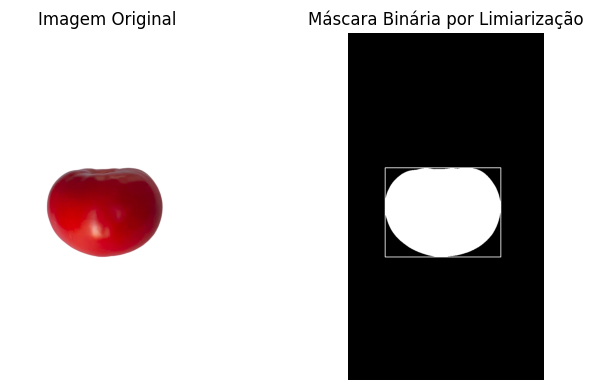

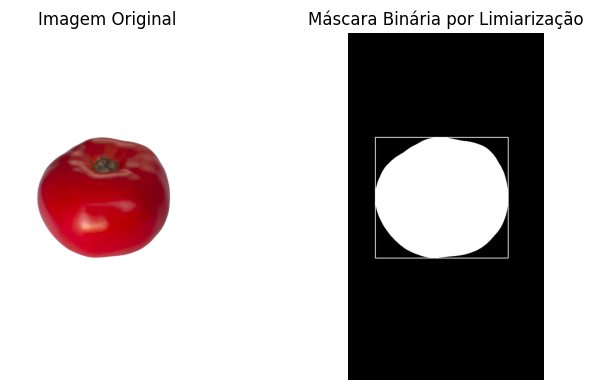

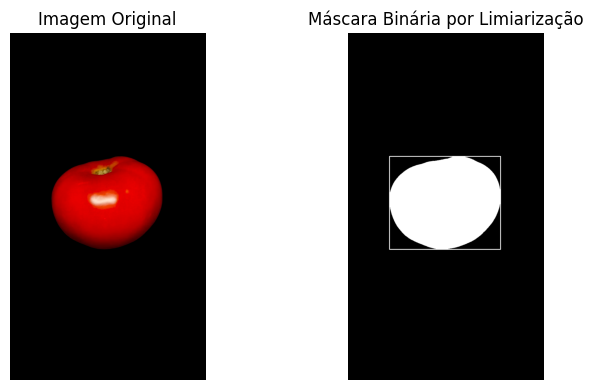

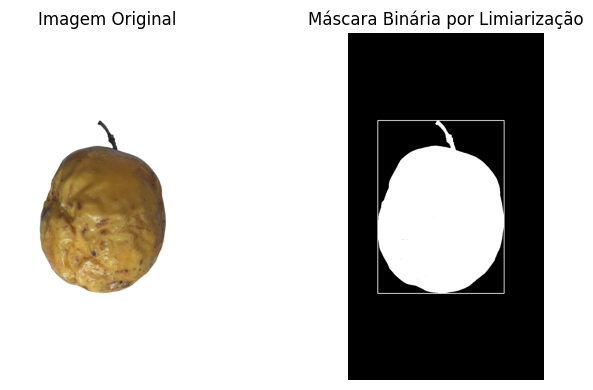

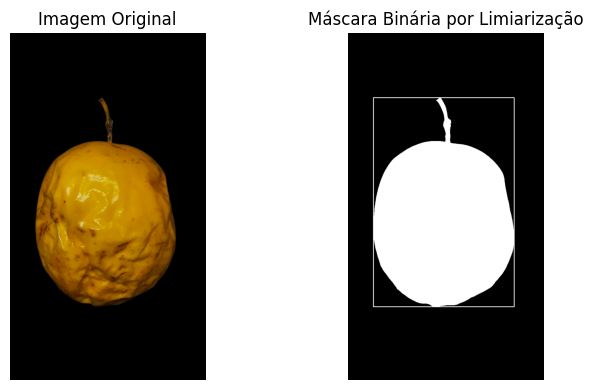

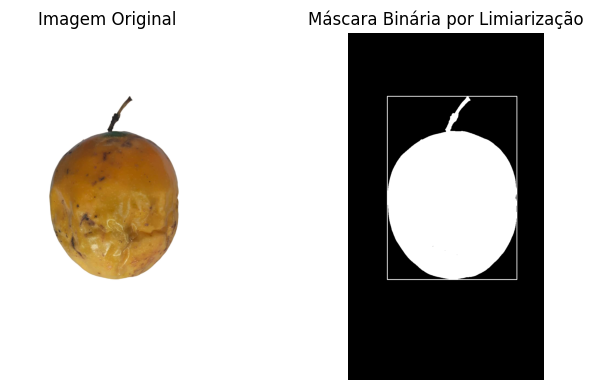

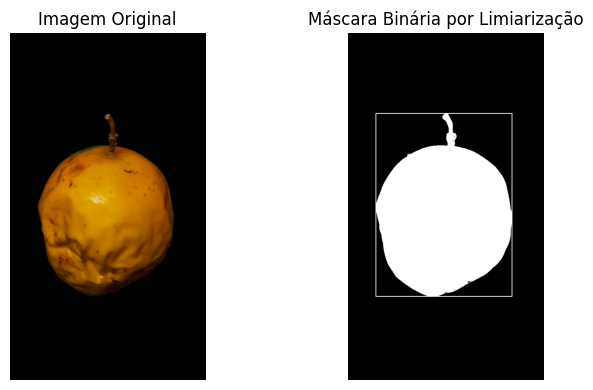

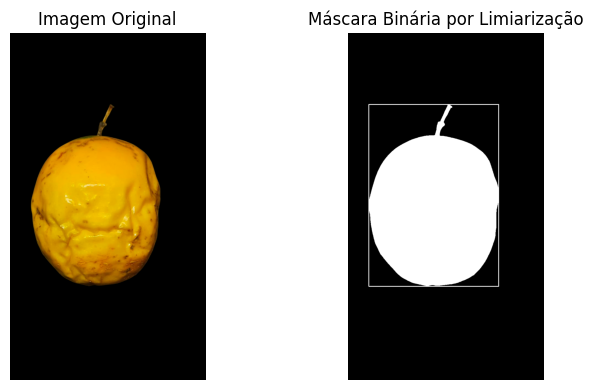

In [3]:
threshold_value_black = 10 # Limiar para fundo preto (passa-alta)
threshold_value_white = 225  # Limiar para fundo branco (passa-baixa)

feature_vectors = []  # Lista para armazenar os vetores de características
labels = []  # Lista para armazenar os rótulos

for classe in classes:
    folder = f'/content/Projeto-PDI/fruits-images-pre-processed/{classe}/*.png'
    images_path = glob.glob(folder)

    for image_path in images_path:
        img = cv2.imread(image_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Verifica o sufixo para determinar o tipo de fundo (B para preto, W para branco)
        if image_path.endswith('-B.png'):
            _, mask = cv2.threshold(img_gray, threshold_value_black, 255, cv2.THRESH_BINARY)
        elif image_path.endswith('-W.png'):
            _, mask = cv2.threshold(img_gray, threshold_value_white, 255, cv2.THRESH_BINARY)
            # Inverte a máscara para o fundo branco
            mask = cv2.bitwise_not(mask)


        #BOUNDING BOX
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Desenha um retângulo delimitador para cada contorno encontrado
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), 2)  # Desenha o retângulo na máscara

            #Obtendo características do conteúdo dentro do bounding box
            area = w * h
            aspect_ratio = float(w) / h if h != 0 else 0
            centroid_x = x + w // 2
            centroid_y = y + h // 2

            # Adiciona o parâmetros obtidos ao vetor de características
            feature_vector = [area, aspect_ratio, centroid_x, centroid_y]
            feature_vectors.append(feature_vector)

            # Adiciona rótulos cda classe
            labels.append(classes.index(classe))

        # Visualizando a imagem original e sua máscara
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Imagem Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Máscara Binária por Limiarização')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Classificação das imagens

In [4]:
# Carregando as imagens

classes = ['APPLE', 'BANANA', 'GRAPE', 'LEMON', 'MANGO', 'ORANGE', 'PEACH',
           'PEAR', 'TOMATO', 'YELLOW_PASSION_FRUIT']

images = []
y = []
for i, classe in enumerate(classes):
  folder = f'/content/Projeto-PDI/fruits-images-augmented/{classe}/*.png'
  images_path = glob.glob(folder)

  for image_path in images_path:
    img = cv2.imread(image_path)
    images.append(img)
    y.append(i)

x = np.array(images)
y = np.array(y)
x = np.reshape(x, (200, 720*1280*3))

In [5]:
from sklearn.model_selection import train_test_split
# dividindo o conjunto de dados em 80% treinamento e 20% para o restante
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

# Dividindo o restante (20%) em 50% para validação e 50% para teste
x_train_val, x_val, y_train_val, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Verificando o tamanho de cada conjunto de dados
print("Tamanho do conjunto de treinamento:", len(x_train))
print("Tamanho do conjunto de validação:", len(x_train_val))
print("Tamanho do conjunto de teste:", len(x_val))

Tamanho do conjunto de treinamento: 160
Tamanho do conjunto de validação: 20
Tamanho do conjunto de teste: 20


In [6]:
from sklearn import tree
#Treinamento da arvore de decisão
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

#Predição
y_pred = clf.predict(x_test)

#Avaliando o desempenho do classificador

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))

# Faz predições nos dados de validação
y_pred_val = clf.predict(x_val)

from sklearn.metrics import accuracy_score
# Avalia a acurácia nas predições dos dados de validação
accuracy = accuracy_score(y_val, y_pred_val)
print("Acurácia no conjunto de validação:", accuracy)

                      precision    recall  f1-score   support

               APPLE       1.00      0.50      0.67         4
              BANANA       0.50      1.00      0.67         3
               GRAPE       0.50      1.00      0.67         1
               LEMON       0.60      0.60      0.60         5
               MANGO       1.00      0.29      0.44         7
              ORANGE       0.50      0.33      0.40         6
               PEACH       0.67      1.00      0.80         4
                PEAR       1.00      0.25      0.40         4
              TOMATO       0.50      0.75      0.60         4
YELLOW_PASSION_FRUIT       0.33      1.00      0.50         2

            accuracy                           0.57        40
           macro avg       0.66      0.67      0.57        40
        weighted avg       0.71      0.57      0.55        40

Acurácia no conjunto de validação: 0.6


Confusion matrix:
[[2 0 0 1 0 0 0 0 1 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 3 0 1 1 0 0 0]
 [0 0 1 0 2 0 0 0 2 2]
 [0 2 0 1 0 2 0 0 0 1]
 [0 0 0 0 0 0 4 0 0 0]
 [0 1 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 1 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 2]]

0 - apple | 1 - banana | 2 - grape | 3 - lemon | 4 - mango | 5 - orange | 6 - Peach | 7 - Pear | 8 - tomato | 9 - yellow_passion_fruit



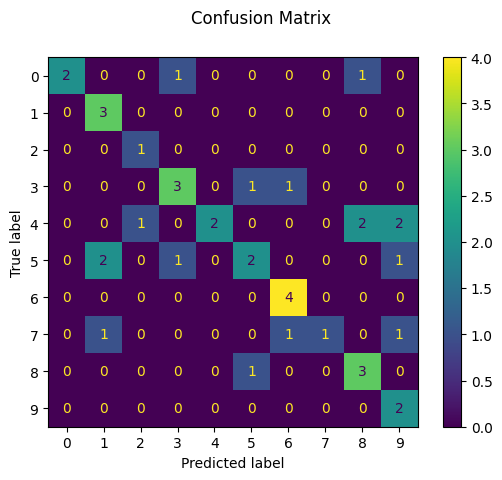

In [8]:
from sklearn import metrics

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

disp.figure_.suptitle("Confusion Matrix")

print(f"Confusion matrix:\n{disp.confusion_matrix}")

print('\n0 - apple | 1 - banana | 2 - grape | 3 - lemon | 4 - mango | 5 - orange | '+\
      '6 - Peach | 7 - Pear | 8 - tomato | 9 - yellow_passion_fruit\n')
plt.show()
